In [1]:
import h5py
import pandas
import numpy
import os
import glob
from collections import defaultdict
import trodes.read_exported
import pandas as pd
import numpy as np
from scipy import stats
from spectral_connectivity import Multitaper, Connectivity
import logging
import h5py
import pickle
import math
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from itertools import combinations
from itertools import permutations
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
import seaborn as sns

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# to graph freq on x axis power on y axis from freq 1-80 Hz, plot average power across freq for social agent type 
# five graphs ; 1 per brain region 

# same thing for coherence and and granger causuality and error bar 

# also plot average baseline power during ITI 


In [3]:
class lfprecording():


    def __init__(self, lfp_all_df, ecu =False):
        self.ecu = ecu
        #get metadata
        self.get_meta_data(lfp_all_df)
        #get unfitlered traces
        self.get_raw_traces(lfp_all_df)
        self.get_zscore_traces(lfp_all_df)
        self.get_rms_traces(lfp_all_df)
        #get filter and filtered traces
        self.get_filter(lfp_all_df)
        self.get_raw_filtered(lfp_all_df)
        self.get_rms_filtered(lfp_all_df)
        #get power
        self.get_power(lfp_all_df)\
        #get bands and phases but this is broken
        #self.get_band_phases(lfp_all_df)
        #get coherence
        self.get_coherence(lfp_all_df)
        #get granger causalities
        self.get_grangers(lfp_all_df)

    def get_meta_data(self, lfp_all_df):
        """
        Saves five attributes: 
            self.session_dir: str, is the parent .rec folder name 
            self.merged_rec: str, is the merged.rec file name
            self.subject: str, subject
            self.first_timestamp: int, first timestamp of the recording
            self.len_recording: int, number of the samples taken after the start of the recording taken at 20,000Hz
        """
        self.session_dir = lfp_all_df.at[0, 'session_dir']
        self.merged_rec = lfp_all_df.at[0, 'original_file']
        self.subject = lfp_all_df.at[0, 'subject']
        self.first_timestamp = lfp_all_df.at[0,'first_timestamp']
        self.len_recording = lfp_all_df.at[0,'data'].shape[0]
        if self.ecu:
            pass

    def get_raw_traces(self, lfp_all_df): 
        """
        Extracts the five columns with raw LFP traces, as well as the brain regions
        from the column names to intitate a brain region order guide 

        Attributes assigned: 
            self.raw_traces: np array, dimensions (b x t) where b is the number of brain regions
                and t is the number of timebins, raw traces taken at 1000 Hz timebins
            self.brain_regions: list of str, the order that the columns appeared and therefore the 
                order of the brian region traces in raw_traces
            self.brain_region_dict: dict, keys are str of brian region names and values are int, that are
                the index of the brain region in brain_regions
            self.mad: list of floats, median absolute deviance of the raw traces per brain region 
        """
        columns_to_stack = []
        brain_regions = []
        mad = []
        #iterate through the columns i think are the right columns
        for col in lfp_all_df.columns[38:43]:
            #i think the names if the columns are region_lfp_trace
            parts = col.split('_')
            #confirm before adding
            if (parts[1] == 'lfp') & (parts[2] == 'trace'):
                #add brain regions to a list to standardize order of data
                brain_regions.append(parts[0])
                columns_to_stack.append(col)
                mad_column = parts[0]+'_lfp_MAD'
                mad.append(lfp_all_df.at[0, mad_column])
            else:
                print('dataframe not organized the same')
        #stack the arrays into brain regions x traces numpy array) 
        self.raw_traces = np.vstack([lfp_all_df[col].values[0] for col in columns_to_stack])
        self.brain_regions = brain_regions
        self.brain_region_dict = {brain_regions[i]: i for i in range(len(brain_regions))}
        self.mad = mad

    def extract_data(self, lfp_all_df,
                   start, end,
                   test_part_1, test_word_1,
                   test_part_2, test_word_2):
        columns_to_stack = []
        temp_brain_regions = []
        #iterate through the columns i think are the right columns
        for col in lfp_all_df.columns[start:end]:
            parts = col.split('_')
            #confirm before adding
            if (parts[test_part_1] == test_word_1) & (parts[test_part_2] == test_word_2):
                #add brain regions to a list to standardize order of data
                temp_brain_regions.append(parts[0])
                columns_to_stack.append(col)
            else:
                print('dataframe not organized the same')
                break
        return(temp_brain_regions, columns_to_stack)

    def order_arrays(self, traces, temp_brain_regions):    
        if temp_brain_regions == self.brain_regions:
            return(traces)
        else: #if not, reorder 
            reordered_array = [None] * len(temp_brain_regions)
            for i in range(len(self.brain_regions)):
                reordered_index = self.brain_region_dict[temp_brain_regions[i]]
                reordered_array[reordered_index] = traces[i]
            return(reordered_array)
        
    def get_traces(self, lfp_all_df,
                   start, end,
                   test_part_1, test_word_1,
                   test_part_2, test_word_2):
        """
        Doc string 
        """
        temp_brain_regions, columns_to_stack = self.extract_data(lfp_all_df,
                                                                start, end,
                                                                test_part_1, test_word_1,
                                                                test_part_2, test_word_2)
        #stack the arrays into brain regions x traces numpy array) 
        traces = np.vstack([lfp_all_df[col].values[0] for col in columns_to_stack])
        #double check to make sure the order of the traces are the same as the raw
        return(self.order_arrays(traces, temp_brain_regions))
    
    def get_frequencies(self, lfp_all_df, start, end, test_part_1, test_word_1, test_part_2, test_word_2):
            """
            """
            temp_brain_regions, columns_to_stack = self.extract_data(lfp_all_df,
                                                                    start, end,
                                                                    test_part_1, test_word_1,
                                                                    test_part_2, test_word_2)
            frequency_arrays = np.stack([lfp_all_df[col].values[0] for col in columns_to_stack], axis = 0)
            return(self.order_arrays(frequency_arrays, temp_brain_regions))

    def get_zscore_traces(self, lfp_all_df): 
        """
        Extracts the five columns with zscored LFP traces, as well as the brain regions
        from the column names to intitate a brain region order guide 
        The names if the columns should be mPFC_lfp_modified_zscore

        Attributes assigned: 
            self.zscore_traces: np array, dimensions (b x t) where b is the number of brain regions
                and t is the number of timebins, raw traces taken at 1000 Hz timebins
        """
        self.zscore_traces = self.get_traces(lfp_all_df,
                                             start = 50, end = 55,
                                             test_part_1= 2, test_word_1 = 'modified',
                                             test_part_2= 3, test_word_2='zscore')

    def get_rms_traces(self, lfp_all_df):
        """
        Extract data from columns that are region_lfp_RMS
        """
        self.rms_traces = self.get_traces(lfp_all_df,
                                          start = 55, end = 60,
                                          test_part_1=1, test_word_1='lfp',
                                          test_part_2=2, test_word_2 = 'RMS')
        
    def get_filter(self, lfp_all_df):
        """
        Extracts the masks for each brain regions, i.e. a numpy array of booleans 
        where false = no noise, nd true = noise 
        """
        self.filter = self.get_traces(lfp_all_df,
                                      start = 60, end = 65,
                                      test_part_1=1, test_word_1='lfp',
                                      test_part_2=2, test_word_2='mask')
    
    def get_raw_filtered(self, lfp_all_df):
        """
        Extracts filtered raw traces, where noise gets a Nan
        """
        self.filtered_raw = self.get_traces(lfp_all_df,
                                      start = 65, end = 70,
                                      test_part_1=2, test_word_1='trace',
                                      test_part_2=3, test_word_2='filtered')
        

    def get_rms_filtered(self, lfp_all_df):
        """
        Extracts filtered RMS traces, where noise gets a Nan
        """
        self.filtered_rms = self.get_traces(lfp_all_df,
                                      start = 70, end = 75,
                                      test_part_1=2, test_word_1='RMS',
                                      test_part_2=3, test_word_2='filtered')
    
    def get_power(self, lfp_all_df):
        """
        Extracts power across frequencies for RMS filtered traces. 
            self.power: np array, dim (b x t x f) where b is the number of brain regions, t is the number of 
                time bins which as 2 data points per sec (2Hz), and f is the number of frequencies 
                power was calculated for 
            self.power_timestamps: np array, dim (1) the timestamps for each data point in the original 20000Hz
            self.power_calculation_frequencies: np array, dim (1), the frequencies that match up with the third 
                dimension of self.power 
        """
        self.power = self.get_frequencies(lfp_all_df,
                                      start = 90, end = 95,
                                      test_part_1=1, test_word_1='RMS',
                                      test_part_2=5, test_word_2='frequencies')
        self.power_timestamps = lfp_all_df.at[0, 'power_timestamps']
        self.power_calculation_frequencies = lfp_all_df.at[0,'power_calculation_frequencies']

    def get_band_phases(self, lfp_all_df):
        """
        This is broken for your data, all bands are Nans
        """
        self.theta_bands = self.get_traces(lfp_all_df, start = 97, end = 102, 
                                           test_part_1=1, test_word_1='theta',
                                           test_part_2=2, test_word_2='band')
        self.gamma_bands = self.get_traces(lfp_all_df, start = 102, end = 107,
                                           test_part_1=1, test_word_1='gamma',
                                           test_part_2=2, test_word_2='band')
        self.theta_phases = self.get_traces(lfp_all_df, start = 107, end = 112,
                                           test_part_1=1, test_word_1='theta',
                                           test_part_2=2, test_word_2='phase')
        self.gamma_phases = self.get_traces(lfp_all_df, start = 112, end = 117,
                                           test_part_1=1,test_word_1='gamma',
                                           test_part_2=2, test_word_2='phase')
    
    def get_coherence(self, lfp_all_df):
        """
        Extracts and saves coherence arrays 
            self.coherence: np arary, dim(bps, t, f) array where bps is the number of brain region pairs,
                t is the number of timebins and f is the number of frequencies, the first dimension 
            self.
            self.coherence_timestamps: np array, dim (1) the timestamps for each data point in the original 20000Hz ? 
            self.cohgerence_calculation_frequencies: np array, dim (1), the frequencies that match up with the third
                dimension of self.coherence
        """
        columns_to_stack = []
        pairs = []
        for col in lfp_all_df.columns[119:197:8]:
            parts = col.split('_')
            pairs.append(parts[0] + '_' + parts[1])
            columns_to_stack.append(col)
        self.coherence_pairs = pairs
        self.coherence = np.stack([lfp_all_df[col].values[0] for col in columns_to_stack], axis = 0)
        self.coherence_timestamps = lfp_all_df.at[0, 'coherence_timestamps']
        self.coherence_calculation_frequencies = lfp_all_df.at[0,'coherence_calculation_frequencies']
        self.coherence_pairs_dict = {pairs[i]: i for i in range(len(pairs))}

    def get_grangers(self, lfp_all_df):
        """
        Extracts and saves granger causality arrays 
            self.grangers: np arary, dim(b, b, t, f) array where b is the number of brain regions,
                t is the number of timebins and f is the number of frequencies, the first dimension 
                is the initiator in the granger causality calculation and the second dimension is the 
                receieving brain region [1,2,:,:] = the granger causality of 1 to 2; [1,1,:,:] is all zeros
            self.granger_timestamps: np array, dim (1) the timestamps for each data point in the original 20000Hz ? 
            self.granger_calculation_frequencies: np array, dim (1), the frequencies that match up with the fourth 
                dimension of self.grangers
        """
        #BLA_mPFC_granger_all_frequencies_all_windows
        is_first = True
        no_regions = len(self.brain_regions)
        for i in range(no_regions):
            for j in range(no_regions):
                if i != j:
                    column = self.brain_regions[i] + '_' + self.brain_regions[j] + '_granger_all_frequencies_all_windows'
                    if is_first:
                        grangers = np.zeros([no_regions, no_regions,
                                 lfp_all_df.at[0, column].shape[0],
                                 lfp_all_df.at[0, column].shape[1]])
                        grangers[i,j] = lfp_all_df.at[0, column]
                        is_first = False
                    else:
                        grangers[i,j] = lfp_all_df.at[0, column]
                else:
                    pass
        self.grangers = grangers
        self.granger_timestamps = lfp_all_df.at[0, 'granger_timestamps']
        self.granger_calculation_frequencies = lfp_all_df.at[0,'granger_calculation_frequencies']
                    

    
        

In [4]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5

In [61]:
class LFPAnalysis:

    def __init__(self, lfp_objects,
                 sampling_rate=20000,
                 down_sample=1000,
                 freq_window = 0.5,
                 freq_smooth_win = 1):
        """
        lfp_objects: list of lfprecording instances 
        sampling_rate: int, default=20000, sampling rate of ephys device in Hz
        down_sample: int, default=1000, down sample rate of LFP traces in Hz
        freq_winddow: float, default=0.5, timebin in seconds for frequency based arrays such as
            power, coherence, and granger 
        freq_smooth_win: float, default=1, size of smoothing window in sec to calculate power,
            coherence, and granger causality   
        """
        self.sampling_rate = sampling_rate
        self.down_sample = down_sample
        self.collection = lfp_objects
        self.brain_regions = lfp_objects[0].brain_regions
        self.power_frequencies = lfp_objects[0].power_calculation_frequencies
        self.coherence_frequencies = lfp_objects[0].coherence_calculation_frequencies
        self.granger_frequencies = lfp_objects[0].granger_calculation_frequencies
        self.brain_region_dict = lfp_objects[0].brain_region_dict
        self.coherence_pairs = lfp_objects[0].coherence_pairs
        self.coherence_pairs_dict = lfp_objects[0].coherence_pairs_dict
        self.freq_window = freq_window
        self.freq_smooth_win = freq_smooth_win
        self.all_set()

    def all_set(self):
        """
        double checks that all lfp objects in the collection have 
        the attributes: subject & event_dict assigned to them and that
        each event_dict has the same keys.

        Prints statements telling user which recordings are missing subjects
        or event_dicts.
        Prints event_dict.keys() if they are not the same.
        Prints "All set to analyze" and calculates spiketrains
        and firing rates if all set.
        """
        is_first = True
        is_good = True
        missing_events = []
        missing_subject = []
        event_dicts_same = True
        for i in range(len(self.collection)):
            recording = self.collection[i]
            if not hasattr(recording, "event_dict"):
                missing_events.append(recording)
            else:
                if is_first:
                    last_recording_events = recording.event_dict.keys()
                    is_first = False
                else:
                    if recording.event_dict.keys() != last_recording_events:
                        event_dicts_same = False
            if not hasattr(recording, "subject"):
                missing_subject.append(recording_name)
        if len(missing_events) > 0:
            print(
                "These recordings are missing event dictionaries:")
            print(f"{missing_events}")
            is_good = False
        else:
            if not event_dicts_same:
                print(
                 "Your event dictionary keys are different across recordings."
                )
                print("Please double check them:")
                for (
                    recording_name,
                    recording,
                ) in self.ephyscollection.collection.items():
                    print(recording_name, "keys:", recording.event_dict.keys())
        if len(missing_subject) > 0:
            print(f"These recordings are missing subjects: {missing_subject}")
            is_good = False
        if is_good:
            print("All set to analyze")

    def plot_average_events(self, event_averages, mode, regions=None):
        if mode == "power":
            self.plot_power_averages(event_averages, regions)
        if mode == 'coherence':
            self.plot_coherence_averages(event_averages, regions)
        if mode == 'granger':
            self.plot_granger_averages(event_averages, regions)
      
    def plot_power_averages(self, event_averages, regions=None):
        if regions == None:
            regions = self.brain_regions
        for region in regions:
            plt.figure(figsize=(10, 5))
            for event, averages in event_averages.items(): 
                #averages = [trials, b, f]
                averages = event_averages[event]
                event_average = np.nanmean(averages, axis = 0)
                # event_average = [b,f]; average across all trials
                #calculate sem for the trial average
                event_sem = stats.sem(averages, axis = 0, nan_policy='omit')
                region_index = self.brain_region_dict[region]
                #pick only the region of interest
                y = event_average[region_index,1:100]
                y_sem = event_sem[region_index,1:100] 
                x = self.power_frequencies[1:100]
                line, = plt.plot(x, y, label = event)
                plt.fill_between(x, y - y_sem, y + y_sem, alpha = 0.2, color = line.get_color())
            ymin, ymax = plt.ylim()
            plt.axvline(x = 12, color='gray', linestyle='--', linewidth=0.5)
            plt.axvline(x = 4, color='gray', linestyle='--', linewidth=0.5)
            plt.fill_betweenx(y=np.linspace(ymin, ymax, 100), x1=4, x2=12, color='red', alpha=0.1)
            plt.ylim(ymin, ymax)
            plt.title(f"{region} power")
            plt.legend()
            plt.show()

    def plot_coherence_averages(self, event_averages, regions=None):  
        if regions is not None:
            pairs_indices = []
            for region in regions:
                try: 
                    pairs_index = self.coherence_pairs_dict[region[0] + '_' + region[1]]
                except KeyError:
                    pairs_index = self.coherence_pairs_dict[region[1] + '_' + region[0]]
                pairs_indices.append(pairs_index)
        if regions is None:
            pairs_indices = range(len(self.coherence_pairs))
            regions = self.coherence_pairs
        for i in range(len(regions)):
            for event, averages in event_averages.items(): 
                #averages = [trials, b, f]
                parts = regions[i].split('_')
                averages = event_averages[event]
                event_average = np.nanmean(averages, axis = 0)
                # event_average = [b,f]; average across all trials
                #calculate sem for the trial average
                event_sem = stats.sem(averages, axis = 0, nan_policy='omit')
                #pick only the region of interest
                y_sem = event_sem[pairs_indices[i],1:100]
                y = event_average[pairs_indices[i],1:100]
                x = self.coherence_frequencies[1:100]
                line, = plt.plot(x, y, label = event) 
                plt.fill_between(x, y - y_sem, y +y_sem, color = line.get_color(), alpha = 0.2)
            ymin, ymax = plt.ylim()
            plt.axvline(x = 12, color='gray', linestyle='--', linewidth=0.5)
            plt.axvline(x = 4, color='gray', linestyle='--', linewidth=0.5)
            plt.fill_betweenx(y=np.linspace(ymin, ymax, 100), x1=4, x2=12, color='red', alpha=0.1)
            plt.ylim(ymin, ymax)
            plt.title(f"{parts[0]} & {parts[1]} coherence")
            plt.legend()
            plt.show()
            
    def plot_granger_averages(self, event_averages, regions=None):
        if regions is not None:
            pair_indices = []
            for region in regions:
                first_index = self.brain_region_dict[region[0]]
                second_index = self.brain_region_dict[region[1]]
                pair_indices.append([first_index, second_index])
        if regions is None:
            pair_indices = list(permutations(range(len(self.brain_regions)),2))
            regions = []
            for pair in pair_indices:
                regions.append([self.brain_regions[pair[0]],
                                self.brain_regions[pair[1]]])
        for i in range(len(pair_indices)):
            for event, averages in event_averages.items(): 
                #averages = [trials, b, b, f]
                region = regions[i]
                averages = event_averages[event]
                event_average = np.nanmean(averages, axis = 0)
                # event_average = [b,b,f]; average across all trials
                #calculate sem for the trial average
                event_sem = stats.sem(averages, axis = 0, nan_policy='omit')
                #pick only the region of interest
                y_sem = event_sem[pair_indices[i][0], pair_indices[i][1], 1:100]
                y = event_average[pair_indices[i][0], pair_indices[i][1], 1:100]
                x = self.coherence_frequencies[1:100]
                line, = plt.plot(x, y, label = event)
                plt.fill_between(x, y - y_sem, y +y_sem, color = line.get_color(), alpha = 0.2)
            ymin, ymax = plt.ylim()
            plt.axvline(x = 12, color='gray', linestyle='--', linewidth=0.5)
            plt.axvline(x = 4, color='gray', linestyle='--', linewidth=0.5)
            plt.fill_betweenx(y=np.linspace(ymin, ymax, 100), x1=4, x2=12, color='red', alpha=0.1)
            plt.ylim(ymin, ymax)
            plt.title(f"Granger causality: {region[0]} to {region[1]}")
            plt.legend()
            plt.show()
            
    def plot_granger_heatmap(self, events, freq, baseline = None, event_len = None):
        event_grangers = self.average_events(events,
                                             mode = 'granger',
                                             baseline = baseline, 
                                             event_len=event_len,
                                             plot= False)
        vmax = -np.inf
        vmin = np.inf
        for event in events: 
            event_granger = event_grangers[event]
            #event_granger = [trial, b, b, f]
            #calculate average granger per trial
            avg_granger = np.nanmean(event_granger, axis = 0)
            #trim array for only the freq band we are interested in
            freq_granger = avg_granger[:,:, freq[0]:freq[1]]
            #average for that freq band
            avg_freq = np.nanmean(freq_granger, axis = 2) 
            sns.heatmap(avg_freq,
                        xticklabels=self.brain_regions,
                        yticklabels=self.brain_regions,
                        annot=True,
                        cmap="viridis",
                        vmin = vmin,
                        vmax = vmax)
            plt.title(f'{event} Granger Causality from {freq[0]}Hz to {freq[1]}Hz')
            plt.show()

           
    def __get_event_averages__(
        self,
        recording,
        event,
        mode,
        event_len,
        pre_window,
        post_window,
    ):
        """
        takes snippets of power, coherence, or causality for events
        optional pre-event and post-event windows (s) may be included
        all events can also be of equal length by extending
        snippet lengths to the longest event

        Args (6 total, 4 required):
            recording: LFP object instance, recording to get snippets
            event: str, event type of which ehpys snippets happen during
            whole_recording: numpy array, power, coherence, or granger causality
                for the whole recording
            event_len: optional, float, length (s) of events used by padding with
                post event time or trimming events all to event_len (s) long, if not 
                defined, full event is used
            pre_window: int, default=0, seconds prior to start of event
            post_window: int, default=0, seconds after end of event
            
        Returns (1):
            event_averages: list, event specific measures of
                power, coherence, or casualities measures during an event including 
                pre_window & post_windows, accounting for event_len and 
                timebins; if mode is power of coherence, event_snippets has 
                dimensions of [e, b, t, f] where e = no of events, b = no. of 
                brain regions, t = no. of timebins, f = no. of frequencies
                if mode is causality then event snippets has the shape [e, b, b, t, f]
        """
        try: 
            events = recording.event_dict[event]
        except KeyError: 
            print(f'{event} not in event dictionary. Please check spelling')
        event_averages = []
        pre_window = math.ceil(pre_window * 1000)
        post_window = math.ceil(post_window * 1000)
        freq_timebin = self.freq_window * 1000
        if event_len is not None:
            event_len_ms = event_len * 1000
        if mode == 'power':    
            whole_recording = recording.power
        if mode == 'granger':
            whole_recording = recording.grangers
        if mode == 'coherence':
            whole_recording = recording.coherence
        for i in range(events.shape[0]):
            if event_len is not None:
                pre_event = math.ceil((events[i][0] - pre_window) / freq_timebin)
                post_event = math.ceil(
                    (events[i][0] + post_window + event_len_ms) / freq_timebin
                )
            if event_len is None: 
                pre_event = math.ceil((events[i][0] - pre_window) / freq_timebin)
                post_event = math.ceil(
                    (events[i][1] + post_window) / freq_timebin
                )
            if mode != 'granger': #power is [b, t, f]; coherence is [bps, t, f]
                if post_event < whole_recording.shape[1]:
                    event_snippet = whole_recording[:, pre_event:post_event, :]
                    event_average = np.nanmean(event_snippet, axis = 1)
                    event_averages.append(event_average)
            if mode == 'granger': #granger is (b, b, t, f)
                if post_event < whole_recording.shape[2]:
                    event_snippet = whole_recording[:, :, pre_event:post_event, :]
                    event_average = np.nanmean(event_snippet, axis = 2)
                    event_averages.append(event_average)
        return event_averages
    
    def average_events(self, events, mode, baseline = None, event_len=None,
                       pre_window=0, post_window=0, plot = False):
        """
        Calculates average event measurement (power, coherence, or granger) per recording then
        calculates global averages across all recordings from recording averages (to account for 
        differences in event numbers per recording)
        """
        event_averages_dict = {}
        for event in events:
            recording_averages = []
            for recording in self.collection:
                event_averages = self.__get_event_averages__(recording,
                                                            event,
                                                            mode,
                                                            event_len,
                                                            pre_window,
                                                            post_window)
                if baseline is not None:
                    adj_averages = self.__baseline_diff__(recording,
                                                          event_averages,
                                                          baseline,
                                                          mode,
                                                          event_len,
                                                          pre_window=0,
                                                          post_window=0)
                    recording_averages = recording_averages + adj_averages
                else:
                    recording_averages = recording_averages + event_averages
        #recording_averages = [trials, b, f] or [trials, b, b, f]
            event_averages_dict[event] = recording_averages  
        if plot: 
            self.plot_average_events(event_averages_dict, mode)
        return(event_averages_dict)       

    def __baseline_diff__(self,
                          recording,
                          event_averages,
                          baseline,
                          mode,
                          event_len,
                          pre_window,
                          post_window):
        baseline_averages = self.__get_event_averages__(recording,
                                                    baseline,
                                                    mode,
                                                    event_len,
                                                    pre_window,
                                                    post_window)
        baseline_recording = np.mean(np.array(baseline_averages), axis = 0)
        adj_averages = []
        for i in range(len(event_averages)):
            adj_average = event_averages[i] - baseline_recording
            adj_averages.append(adj_average)
        return(adj_averages)
    

In [6]:
base_dir = r"D:\social_ephys_pilot2_cum\data\phase2"
# List all folders in the base directory
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
lfp_recordings = {}
event_dict = unpickle_this('event_dict_phase2.pkl')
# Process each folder
for folder in folders:
    # Construct the full path to the pickle file
    pkl_path = os.path.join(base_dir, folder, 'outputs', 'lfp_all_df.pkl')
    
    # Check if the pickle file exists
    if os.path.exists(pkl_path):
        # Unpickle the file
        unpickled_data = unpickle_this(pkl_path)
        # Extract the variable name from the folder name
        folder_name_parts = folder.split('_')
        recording_name = folder_name_parts[0] + '_' + folder_name_parts[1]
      
        # Assign the unpickled data to a dynamically named variable
        lfp_recordings[recording_name] = unpickled_data

for recording in event_dict.keys():
    recording_parts = recording.split('_')
    recording_name = recording_parts[0] + '_' + recording_parts[1]
    lfp_recordings[recording_name] = lfprecording(lfp_recordings[recording_name])
    lfp_recordings[recording_name].event_dict = event_dict[recording]
    
phase2_recordings = list(lfp_recordings.values())

In [ ]:
test_analysis = LFPAnalysis(phase2_recordings)
t = test_analysis.average_events(events = ['recall', 'cagemate', 'novel', 'acquisition'], mode = 'power', baseline='iti_events', plot = True)

All set to analyze


C:\Users\megha\AppData\Local\Temp\ipykernel_12568\2992462258.py:285: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)
C:\Users\megha\AppData\Local\Temp\ipykernel_12568\2992462258.py:290: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 2)


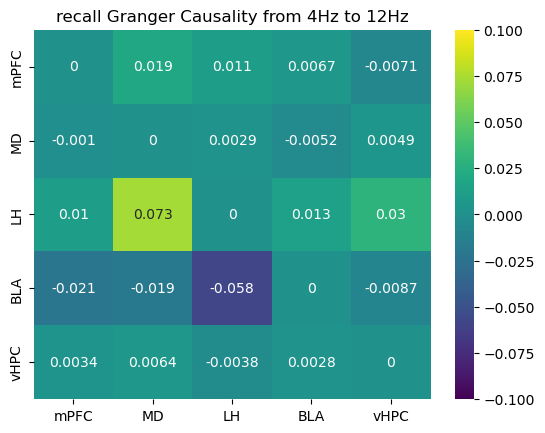

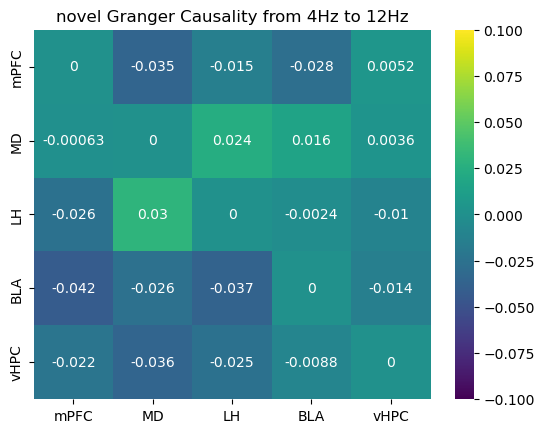

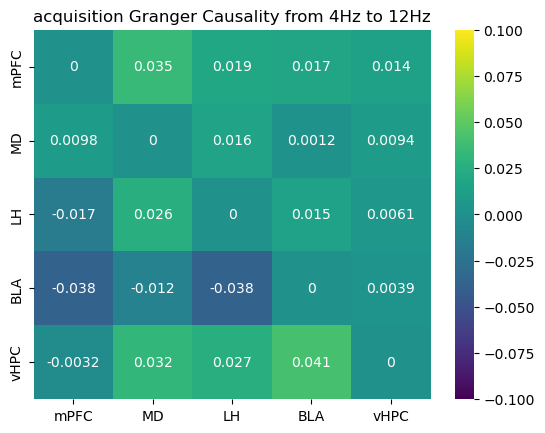

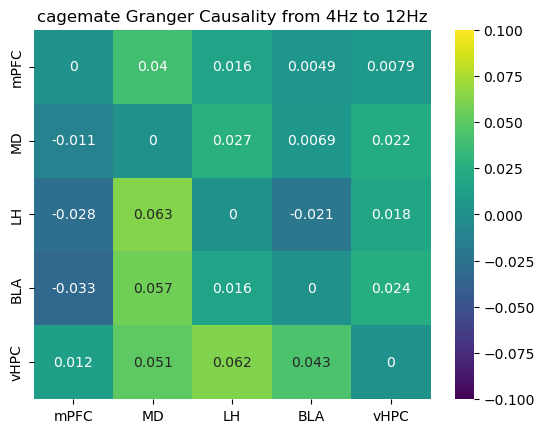

In [62]:
test_analysis = LFPAnalysis(phase2_recordings)

itis = test_analysis.average_events(['iti'], mode = 'power', plot = False)
test_analysis.plot_granger_heatmap(events = ['recall', 'novel','acquisition','cagemate'], freq = [4,12], baseline = 'iti_events')


All set to analyze


C:\Users\megha\AppData\Local\Temp\ipykernel_12568\2992462258.py:285: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 1)


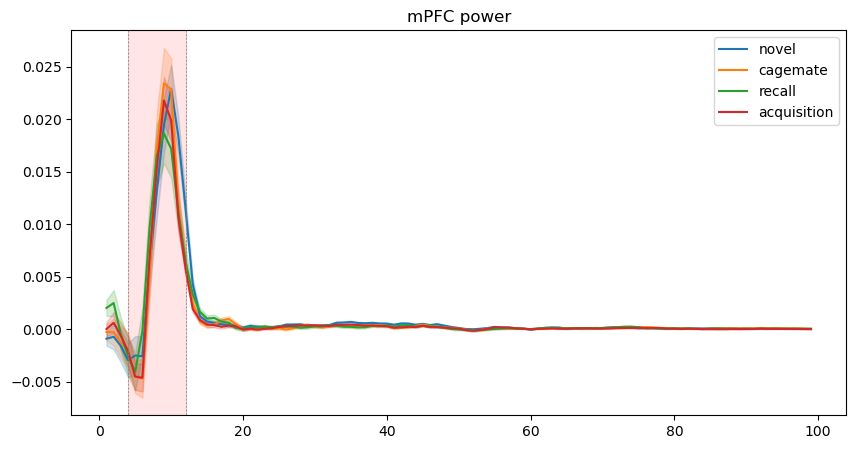

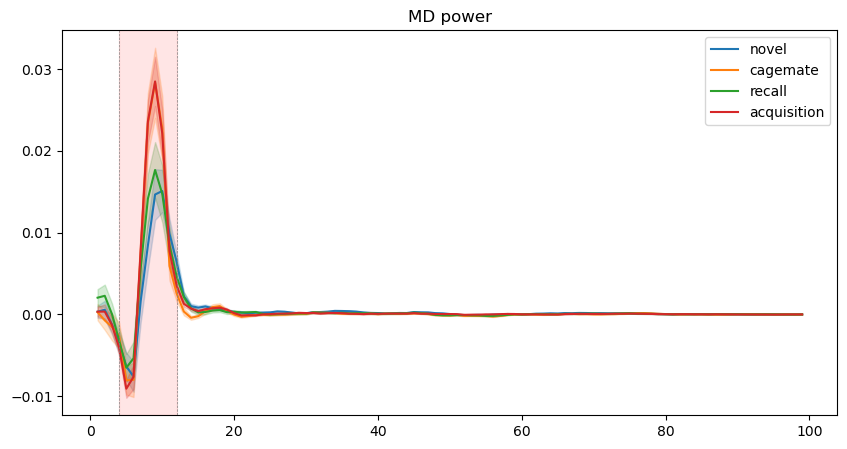

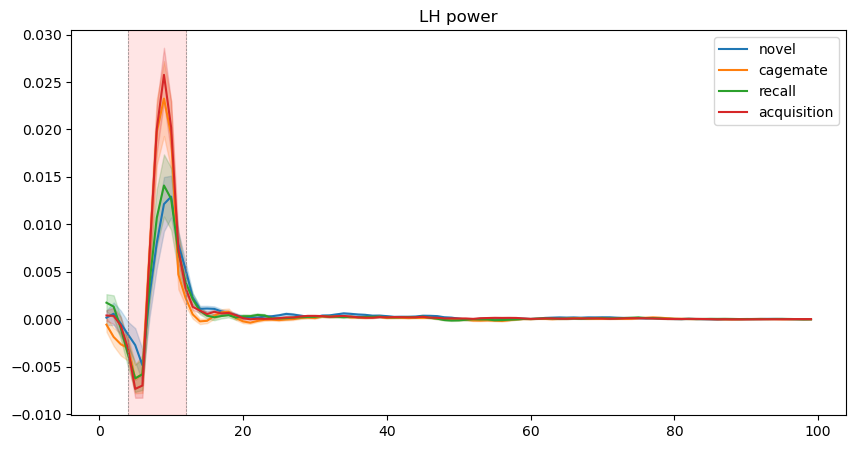

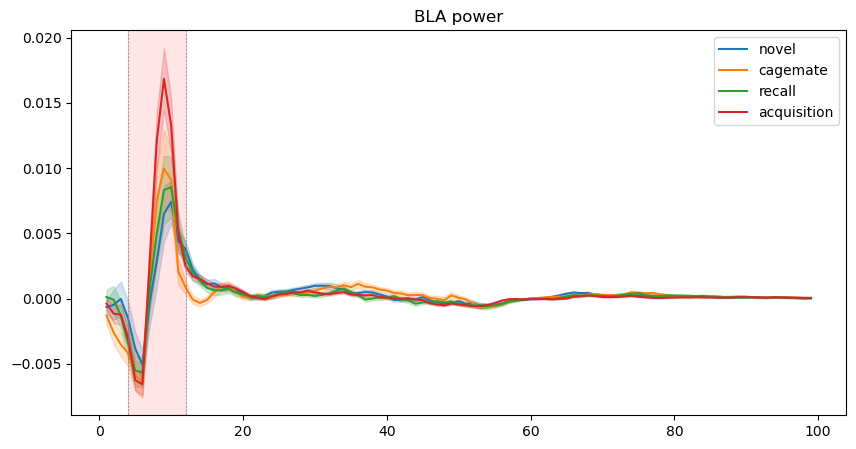

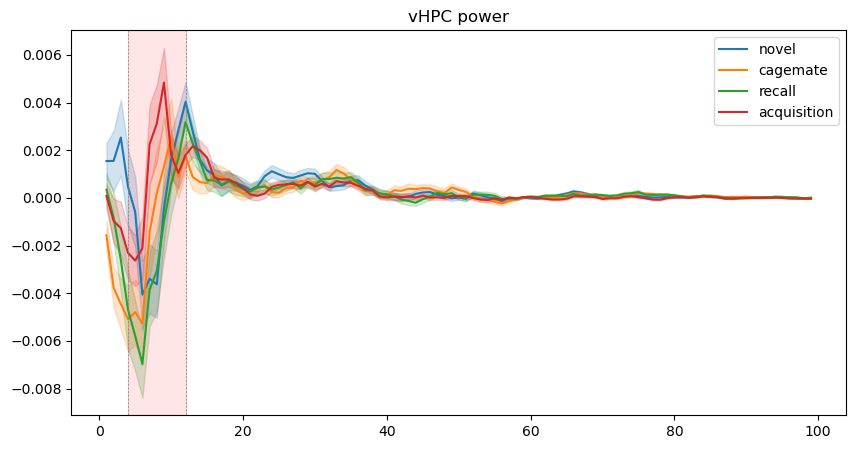

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


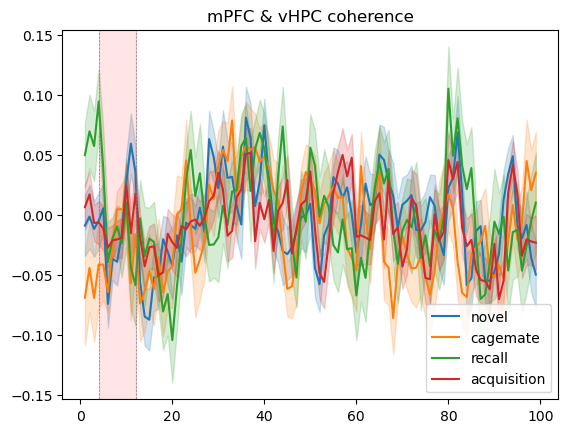

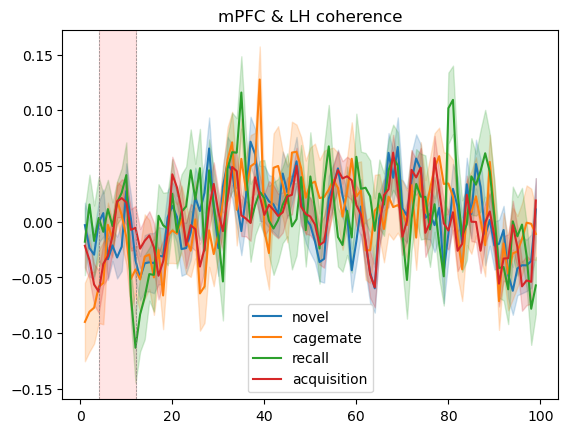

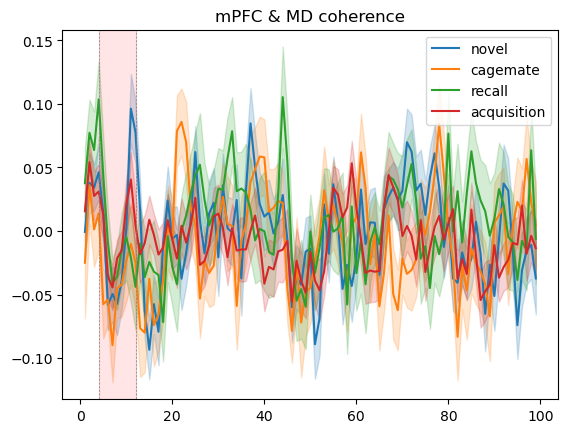

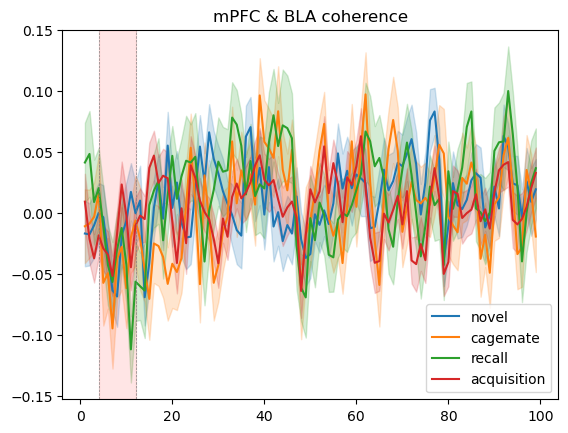

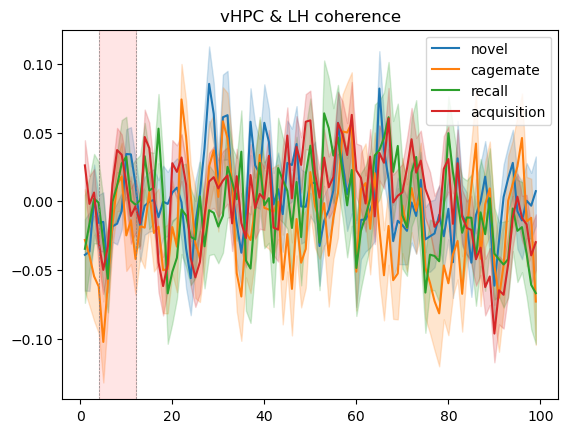

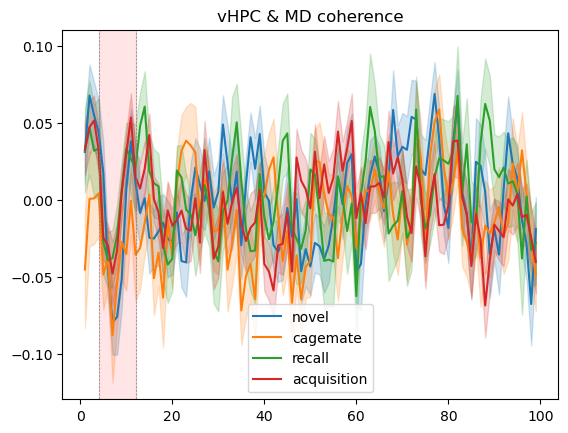

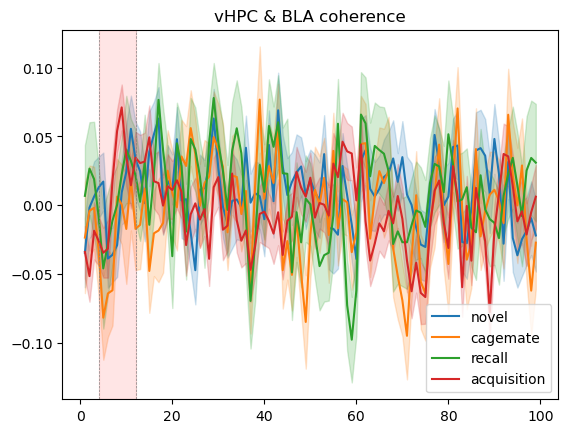

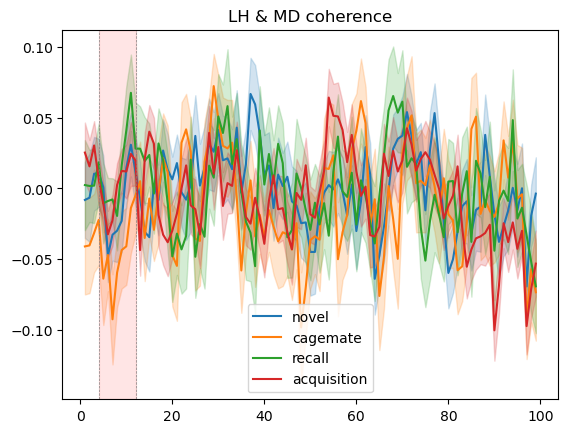

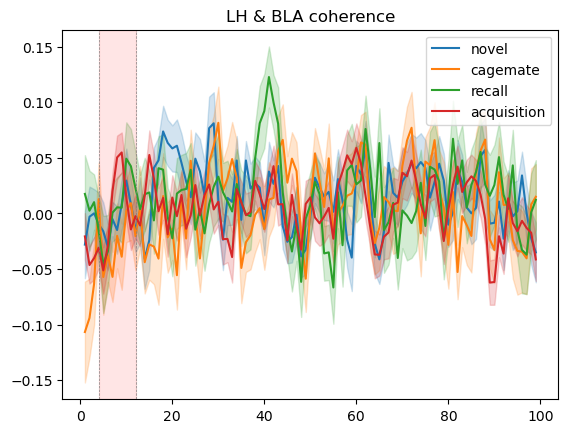

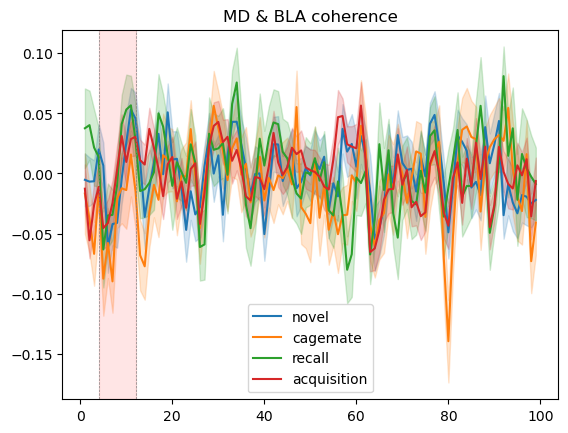

C:\Users\megha\AppData\Local\Temp\ipykernel_12568\2992462258.py:290: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(event_snippet, axis = 2)


In [64]:
test_analysis = LFPAnalysis(phase2_recordings)

average_power = test_analysis.average_events(events = ['novel', 'cagemate', 'recall', 'acquisition'],
                                             mode = 'power',
                                             baseline = 'iti_events',
                                             event_len = None,
                                             pre_window=0,
                                             post_window = 0,
                                             plot = True)
average_coherence = test_analysis.average_events(events = ['novel', 'cagemate', 'recall', 'acquisition'],
                                             mode = 'coherence',
                                             baseline = 'iti_events',
                                             event_len = None,
                                             pre_window=0,
                                             post_window = 0,
                                             plot = True)
average_granger = test_analysis.average_events(events = ['novel', 'cagemate', 'recall', 'acquisition'],
                                             mode = 'granger',
                                             baseline = 'iti_events',
                                             event_len = None,
                                             pre_window=0,
                                             post_window = 0,
                                             plot = False)






looks like data, first_item_data, and last_item_data are the same things...
sample numbers x3 

raw lfp traces

median absolute deviation used for normalizing the signals

these are normalized traces using z score to remove noise and then used as input to RMS


this allows us to compare across animals and this is what we calulcate power on 
root square of the mean

these are boolean numpy arrays false = no noise, true = noise

this is filtered for noise but not RMS-ed

filtered for noise with RMS 

the only columns i should be looking at are RMS_Filtered_power 
2 hz time windows 

42011249 is taken 20000 Hz
2100535 is 1000 Hz (LFP down sample)

1 sec with .5 overlap --> we have 2 data points per second 
500 frequencies (which are listed below) 

should add documentation for what band theta is , so this is LFP with a banded filter (aka only filtering for theta) 

this is phase for that frequency band (-2pi to 2pi for example)

in theory - this should only be done on the RMS filtered although in theory in theory i should check if the filter is good for my data 
a parameter should be the number of SD to be filtered out , with a default of 4, another function to be added to this class should be plotting given brain regions of a zscored data filtered 
also there should be only column for the calculation made for frequencies across all your brain regions i.e. power frequencies, coherence frequencies etc. 